## This script illustrates Decision Trees, K-NN and logistic Regression, SVM Models for Breast Cancer Dataset

Loading all the necessary libraries required for data anaylsis,modelling and visualization 

In [1]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn.datasets import load_breast_cancer
from sklearn import tree,linear_model,neighbors, datasets
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, StandardScaler
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Loading the dataset and have a general look at the data 

In [2]:
# load the data set
# load_breast_cancer() loads and returns the required dataset (classification).
data = load_breast_cancer()
# load_breast_cancer() returns a dictionary-like object. The interesting attributes are: 
# ‘data’, the data to learn, 
# ‘target’, the classification labels, 
# ‘target_names’, the meaning of the labels, 
# ‘feature_names’, the meaning of the features, and 
# ‘DESCR’, the full description of the dataset.
print (data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Exploring the dataset in terms of the dimensions, target variable as well as the attributes which will be used to classify the target variable.

In [3]:
n_samples, n_features = data.data.shape
print ('The dimensions of the data set are', n_samples, 'by', n_features)
print ('The classes are:', data.target_names)
print ('The features in the data set are:', data.feature_names)

The dimensions of the data set are 569 by 30
The classes are: ['malignant' 'benign']
The features in the data set are: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


The data is in the required format so data cleaning or transformation steos is not required 

Splitting holdout data to be 20% which will be later used to evaluate model performance after training the model using cross validation.
Using random sampling because the data set in not imbalanced. the target variable are split in the ratio 0 : 38% and 1: 63%

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.20,random_state=42,stratify = data.target)

In [5]:
scaler = StandardScaler().fit(X_train)
scaler1 = StandardScaler().fit(X_test)
X_train = scaler.transform(X_train)  
X_test = scaler1.transform(X_test)  
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [6]:
type(data.target)
unique, counts = np.unique(data.target, return_counts=True)
dict(zip(unique, counts))

{0: 212, 1: 357}

In [7]:
# Verifying if the ratio is still maintained after random splitting in train and test
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 170, 1: 285}

In [8]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))
# It is verified that the ratio is maintained 

{0: 42, 1: 72}

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### 1. Decision Trees

Algorithms like decision tree has many hyperparameters which we can tweak.Grid Search method from sklearn can be used so that we can test a lot of hyperparamters and do cross validation of each to get the best set of hyper parameters.
Below is the code for decision tree hyperparameter optimization using grid search

Max_depth, min_samples in leaf and min_impurity_decrease hyper parameters is used for the model because max depth and min samples in leaf nodes should put a constraint on the tree growing full to the each individual node which would lead to overfitting and min_impurity_decrease is used to deal with underfitting because if a node is impurity with this threshold the try will try to split it and try to make the leaf nodes pure than the parent.

In [10]:
tuned_parameters = {'max_depth': np.arange(3,7),'min_samples_leaf': np.arange(5,30),"criterion":["gini","entropy"],"min_impurity_decrease":[1e-07,1e-06,1e-05,1e-04,1e-03,1e-02,1e-01,1]}

inner_cv = KFold(n_splits=4, shuffle=True)
outer_cv = KFold(n_splits=4, shuffle=True)

grid_tree = tree.DecisionTreeClassifier(random_state=45)

#Nested CV inner loop
grid = GridSearchCV(grid_tree, tuned_parameters, cv = inner_cv, scoring='f1')
grid.fit(X_train,y_train)

#Nested CV outer loop
nested_score = cross_val_score(grid, data.data, data.target, cv=outer_cv,scoring ='f1')


In [11]:
# Mean Accuracy with +/- 2 std deviations
print("Using Nested CV with grid search,accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std() * 2))
print()
print ("The best hyper-parameters to get this accuracy is :-\n", grid.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid.best_estimator_)
y_pred = grid.best_estimator_.predict(X_test)

#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search,accuracy: 95.05% +/- 5.40%

The best hyper-parameters to get this accuracy is :-
 {'criterion': 'gini', 'max_depth': 6, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 6}

The best decision tree classifier is :-
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=45,
            splitter='best')
Confusion Matrix: - 
 [[39  3]
 [10 62]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.80      0.93      0.86        42
           1       0.95      0.86      0.91        72

   micro avg       0.89      0.89      0.89       114
   macro avg       0.87      0.89      0.88       114
weighted avg       0.90      0.89      0.89       114



**Model Goodness**

The class distribution is 357 benign, 212 malignant, which would get us an accuracy of 357/(357+212) = 62.74% by majority rule, so an **Accuracy of 95.05% +/- 5.40%** by decision tree classification is a good model.

Our model was chosen based of **f1-score which is 89%** which is the harmonic mean of precision and recall and hence a good measure to determine a good fit.

False Negatives can be a problem since it is a medical case and we would like to minimize the number of **false negatives which is 10** in this case.

Therefore, the following Hyperparameters,  'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 6 help us increase the accuracy to 95.05% +/- 5.40%, while maintaining the same f1 score of 89%.

The Predict function from the model takes .5 as threshold, plotting a ROC curve to see if this threshold can be changed to get better results 

ROC Curve :
ROC curve plots the true positive rate and false positive rate for various thresholds. X axis is false positve(1- Sensitivity) rate and Y axis is true positive rate(Specificity). It can be noticed that, when the threshold is high we get all the true postives if the classifier has predicted all the positives correctly and values across Y axis increases and when the threshold is lowered the model starts getting false postives so value across x axis increases and finally reached 1,1 co ordinate. 

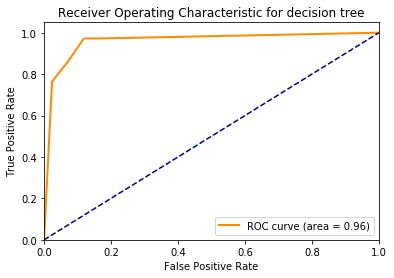

In [12]:
y_score = grid.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for decision tree')
plt.legend(loc="lower right")
plt.show()

The lift curve graphically represents the improvement that a mining model provides when comapred against a random guess for a portion of observations. The lift is > 2.5 for class 1 for the first 40% of the observations later decreases.

C:\Users\vnike\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


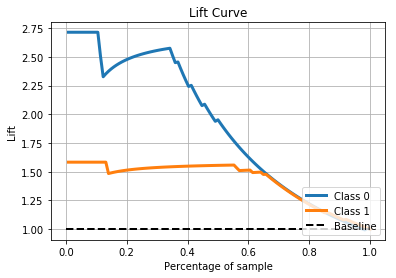

In [13]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score)
plt.show()

The ROC and lift chart shows that the accuracy reaches maximum when the treshold is set to 0.9 above that the False Positives increases.Setting 0.9 as threshold and classifying the test data 

In [16]:
y_pred = np.where(y_score[:,1] > .4,1,0)
#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Confusion Matrix: - 
 [[37  5]
 [ 2 70]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91        42
           1       0.93      0.97      0.95        72

   micro avg       0.94      0.94      0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



Increasing threshold increases the true positives but also increases the false negatives which is not desired.Hence, we can keep the threshold at .4 where false negatives is less

### 2. K-NN  

Nested Grid Search for model selection as well as hyper parameter tuning

In [17]:
param_grid = {'n_neighbors' : np.arange(1,30), 'weights' : ['uniform','distance']}

grid_knn_clf = neighbors.KNeighborsClassifier()

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

#Nested CV innner loop
grid_knn = GridSearchCV(grid_knn_clf, param_grid, cv = inner_cv, scoring='f1')
grid_knn.fit(X_train,y_train)

#Nested CV outer loop
nested_score = cross_val_score(grid_knn, data.data, data.target, cv=outer_cv,scoring='f1')

In [18]:
# Mean Accuracy with +/- 2 std deviations
print("Using Nested CV with grid search,accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std() * 2))
print()
print ("The best hyper-parameters to get this accuracy is :-\n", grid_knn.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid_knn.best_estimator_)
y_pred = grid_knn.best_estimator_.predict(X_test)

#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search,accuracy: 94.35% +/- 1.56%

The best hyper-parameters to get this accuracy is :-
 {'n_neighbors': 6, 'weights': 'distance'}

The best decision tree classifier is :-
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')
Confusion Matrix: - 
 [[39  3]
 [ 0 72]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

   micro avg       0.97      0.97      0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



**Model Goodness**

The class distribution is 357 benign, 212 malignant, which would get us an accuracy of 357/(357+212) = 62.74% by majority rule, so an **Accuracy of 94.35% +/- 1.56%** by decision tree classification is a good model.

Our model was chosen based of **f1-score which is 97%** which is the harmonic mean of precision and recall and hence a good measure to determine a good fit.

False Negatives can be a problem since it is a medical case and we would like to minimize the number of **false negatives which is 0** in this case.

Therefore, the following Hyperparameters,  'n_neighbhors' = 6, weights = 'distance' help us increase the accuracy to 94.35% +/- 1.56%, while maintaining the same f1 score of 97%.

The Predict function from the model takes .5 as threshold, plotting a ROC curve to see if this threshold can be changed to get better results 

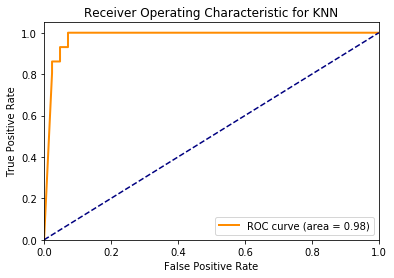

In [19]:
y_score1 = grid_knn.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score1[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc="lower right")
plt.show()

C:\Users\vnike\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


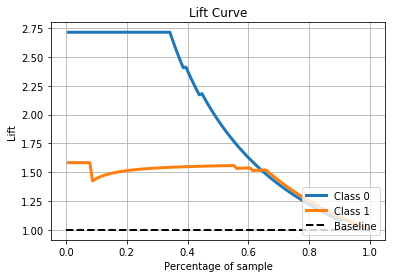

In [20]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score1)
plt.show()

The ROC and lift chart shows that the accuracy reaches maximum when the treshold is set to 0.9

In [21]:
y_pred = np.where(y_score1[:,1] > .6,1,0)
#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Confusion Matrix: - 
 [[39  3]
 [ 0 72]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

   micro avg       0.97      0.97      0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



### 3. Logistic Regression 

In [22]:
grid_values = {'penalty': ['l1', 'l2'], \
               'C':[1e-4,0.001,.009,0.01,.09,1,5,10,25,100,1000,1e4]}

grid_log_clf = linear_model.LogisticRegression(random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_logit = GridSearchCV(grid_log_clf, grid_values, cv = inner_cv, scoring='f1_micro')
grid_logit.fit(X_train,y_train)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_logit, data.data, data.target, cv=outer_cv,scoring = 'f1_micro')

In [23]:
# Mean Accuracy with +/- 2 std deviations
print("Using Nested CV with grid search,accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std() * 2))
print()
print ("The best hyper-parameters to get this accuracy is :-\n", grid_logit.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid_logit.best_estimator_)
y_pred = grid_logit.best_estimator_.predict(X_test)

#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search,accuracy: 97.01% +/- 3.91%

The best hyper-parameters to get this accuracy is :-
 {'C': 0.09, 'penalty': 'l2'}

The best decision tree classifier is :-
 LogisticRegression(C=0.09, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=45, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Confusion Matrix: - 
 [[40  2]
 [ 1 71]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

   micro avg       0.97      0.97      0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



**Model Goodness**

The class distribution is 357 benign, 212 malignant, which would get us an accuracy of 357/(357+212) = 62.74% by majority rule, so an **Accuracy of 97.01% +/- 3.91%** by decision tree classification is a good model.

Our model was chosen based of **f1-score which is 97%** which is the harmonic mean of precision and recall and hence a good measure to determine a good fit.

False Negatives can be a problem since it is a medical case and we would like to minimize the number of **false negatives which is 1** in this case.

Therefore, the following Hyperparameters,  'C' = 0.09, penalty = 'l2' help us increase the accuracy to 97.01% +/- 3.91%, while maintaining the same f1 score of 97%.

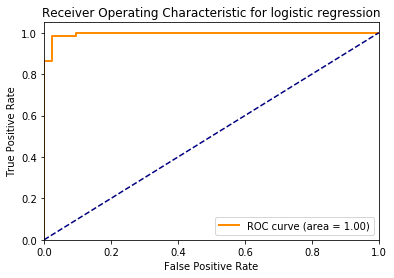

In [24]:
y_score2 = grid_logit.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score2[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

C:\Users\vnike\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


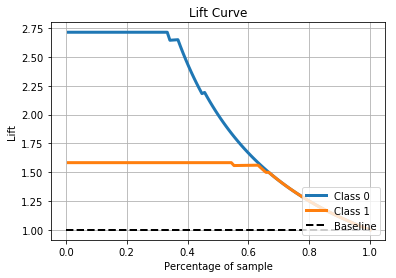

In [25]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score2)
plt.show()

In [26]:
y_pred = np.where(y_score2[:,1] > .5,1,0)
#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Confusion Matrix: - 
 [[40  2]
 [ 1 71]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

   micro avg       0.97      0.97      0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# 4. SVM 

In [10]:
param_grid = {'kernel':['linear','rbf'],'C': [0.01, 0.1, 1, 10, 100], 'gamma' :[0.001, 0.01, 0.1, 1]}

grid_svc_clf= SVC(random_state = 45,probability = True)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_svm = GridSearchCV(grid_svc_clf, param_grid, cv = inner_cv, scoring='f1',n_jobs = -1)
grid_svm.fit(X_train,y_train)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_svm, data.data, data.target, cv=outer_cv,scoring='f1',n_jobs = -1)

In [11]:
# Mean Accuracy with +/- 2 std deviations
print("Using Nested CV with grid search,accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std() * 2))
print()
print ("The best hyper-parameters to get this accuracy is :-\n", grid_svm.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid_svm.best_estimator_)
y_pred = grid_svm.best_estimator_.predict(X_test)

#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search,accuracy: 95.79% +/- 2.64%

The best hyper-parameters to get this accuracy is :-
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

The best decision tree classifier is :-
 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=45, shrinking=True,
  tol=0.001, verbose=False)
Confusion Matrix: - 
 [[41  1]
 [ 1 71]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

   micro avg       0.98      0.98      0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



**Model Goodness**

The class distribution is 357 benign, 212 malignant, which would get us an accuracy of 357/(357+212) = 62.74% by majority rule, so an **Accuracy of 95.79% +/- 2.64%** by decision tree classification is a good model.

Our model was chosen based of **f1-score which is 98%** which is the harmonic mean of precision and recall and hence a good measure to determine a good fit.

False Negatives can be a problem since it is a medical case and we would like to minimize the number of **false negatives which is 1** in this case.

Therefore, the following Hyperparameters,  'C' = 10, kernel = 'rbf',gamma : 0.01 help us increase the accuracy to 95.79% +/- 2.64%, while maintaining the same f1 score of 98%.

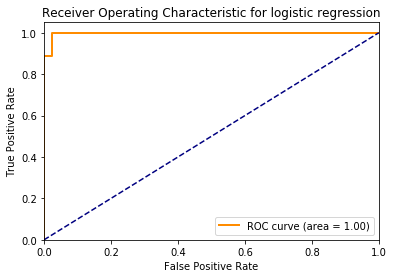

In [12]:
y_score3 = grid_svm.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score3[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

C:\Users\vnike\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


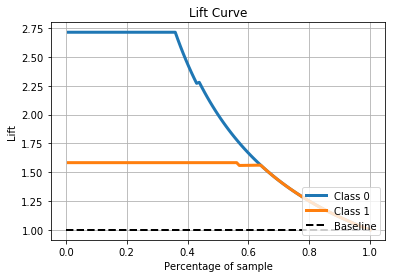

In [13]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score3)
plt.show()

In [17]:
y_pred = np.where(y_score3[:,1] > .6,1,0)
#Goodness Measures confusion matrix and other measures like accuracy, precision,recall
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Confusion Matrix: - 
 [[41  1]
 [ 2 70]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

   micro avg       0.97      0.97      0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

